In [136]:
import pandas as pd
import torch
import numpy as np
from tqdm import tqdm
from torch_geometric.nn import SAGEConv
import torch
import torch_geometric
import torch.nn.functional as F
torch_geometric.set_debug(True)

# Helper Function to Construct the Graph

In [137]:
def mapping(data: pd.DataFrame):
    node_id_mapping, inverse_node_id_mapping = dict(), dict()
    for i, node_id in enumerate(data['image_name']):
        node_id_mapping[i] = node_id
        inverse_node_id_mapping[node_id] = i
    return node_id_mapping, inverse_node_id_mapping

In [138]:
def construct_nodes(data: pd.DataFrame):
    raw_features = data['embedding'].apply(lambda x: (' '.join(x.strip('[').strip(']').strip().split())).split(' '))
    return torch.from_numpy(np.array([[float(val) for val in feature_vector] for feature_vector in raw_features])).to(torch.float32)

In [139]:
def construct_edges(features: torch.tensor, threshold: float, method):
    source, target = [], []
    for i in tqdm(range(features.shape[0])):
        for j in range(i + 1, features.shape[0]):
            if method(features[i], features[j]) > threshold:
                source.append(i)
                target.append(j)
                source.append(j)
                target.append(i)
    return torch.tensor([source, target])

In [140]:
def get_labels(data: pd.DataFrame, subject_mapping):
    labels = data['class_name'].apply(lambda x: subject_mapping[x])
    return torch.tensor(labels)

In [141]:
def cosine_similarity(x: torch.tensor, y: torch.tensor):
    cos = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)
    return cos(x,y)

def city_block(x: torch.tensor, y: torch.tensor):
    return torch.cdist(x, y, p=1)

def euclidian(x: torch.tensor, y: torch.tensor):
    return torch.cdist(x, y, p=2)

# Reading the Data and Exploring

In [142]:
data = pd.read_csv('imagenet_embeddings.csv')

In [143]:
classes = data['class_name'].unique()
subject_mapping = dict()
for i, class_name in enumerate(classes):
    subject_mapping[class_name] = i
subject_mapping

{'lion': 0, 'bear': 1, 'tarantula': 2, 'golden retriever': 3}

In [144]:
x = construct_nodes(data)
y = get_labels(data, subject_mapping)

In [145]:
def construct_matrix(matrix, method):
    n = matrix.shape[0]
    similarity_matrix = np.zeros((n, n))
    for i in tqdm(range(n)):
        for j in range(n):
            similarity_matrix[i][j] = method(matrix[i], matrix[j])
    return similarity_matrix

# Euclidian

In [279]:
euclidian = torch.cdist(x, x, p=2)

# City Block

In [280]:
city_block = torch.cdist(x, x, p=1)

# Max Norm

In [295]:
max_norm = torch.max(torch.abs(x[:, None] - x), dim=2).values

<function Tensor.size>

In [296]:

max_norm.size()

torch.Size([2000, 2000])

# Cosine

In [146]:
from sklearn.metrics.pairwise import cosine_similarity
similarities = cosine_similarity(x)

# BoxPlot

In [254]:
def one_vs_rest(one_class: int, rest: np.array):
    same_class = []
    classes = [[], [], []]
    for i in range(500):
        same_class.append((sum(one_class[i]) - 1) / (len(one_class[i] - 1)))
        for j in range(3):
            rest_class = rest[i][j*500:(j+1)*500]
            classes[j].append(sum(rest_class) / len(rest_class))
    classes.append(same_class)
    return classes

In [281]:
def for_box_plots(similarities: np.array):
    test = []
    for i in tqdm(range(4)):
        relevant_indeces = list(range(i * 500, (i+1) * 500))
        one_class, rest = [], []
        for i in range(2000):
            if i in relevant_indeces:
                one_class.append(similarities[i])
            else:
                rest.append(similarities[i])
        test.append(one_vs_rest(one_class, rest))
    return test


100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


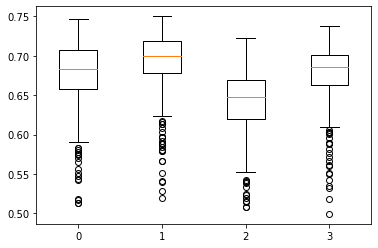

In [257]:
import matplotlib.pyplot as plt

cosine_test = for_box_plots(similarities)
plt.boxplot(cosine_test[0], positions=range(len(cosine_test[0])))
plt.show()

100%|██████████| 4/4 [00:30<00:00,  7.70s/it]


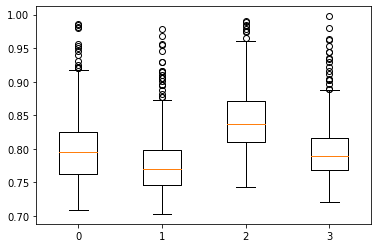

In [282]:
euclidian_test = for_box_plots(euclidian)
plt.boxplot(euclidian_test[0], positions=range(len(euclidian_test[0])))
plt.show()

In [309]:
np.percentile(euclidian_test[0][3], [10, 50, 90])

array([0.75297491, 0.78933421, 0.84796432])

100%|██████████| 4/4 [00:27<00:00,  6.78s/it]


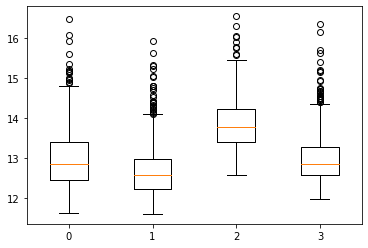

In [283]:
city_block_test = for_box_plots(city_block)
plt.boxplot(city_block_test[0], positions=range(len(city_block_test[0])))
plt.show()

In [284]:
np.percentile(city_block_test[0][3], [10, 50, 90])

array([12.38777609, 12.85571051, 13.79123812])

100%|██████████| 4/4 [00:28<00:00,  7.24s/it]


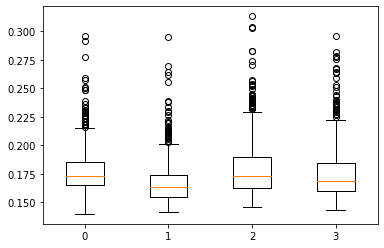

In [297]:
max_norm_test = for_box_plots(max_norm)
plt.boxplot(max_norm_test[0], positions=range(len(max_norm_test[0])))
plt.show()

In [298]:
np.percentile(max_norm_test[0][3], [10, 50, 90])

array([0.15432354, 0.16856233, 0.20794925])

In [260]:
def construct_edges(similarities, lower_threshold, upper_threshold):
    source, target = [], []
    for i in tqdm(range(similarities.shape[0])):
        for j in range(similarities.shape[1]):
            if lower_threshold < similarities[i][j] < upper_threshold and i != j:
                source.append(i)
                target.append(j)
    return torch.tensor([source, target])

In [299]:
edges = construct_edges(max_norm, 0.15, 0.2)

100%|██████████| 2000/2000 [01:02<00:00, 32.05it/s]


# Running GNN

In [318]:
from generate_graph import construct_graph

x, y, edges = construct_graph(pd.read_csv('imagenet_embeddings.csv'), ['euclidian', 0.73, 0.847])

<class 'torch.Tensor'>


  5%|▌         | 103/2000 [00:03<01:03, 30.01it/s]


KeyboardInterrupt: 

In [300]:
train_indeces = list(range(0,400)) + list(range(500,900)) + list(range(1000,1400)) + list(range(1500,1900))
valid_indeces = list(range(400,450)) + list(range(900,950)) + list(range(1400,1450)) + list(range(1900,1950))
test_indeces = list(range(450,500)) + list(range(950,1000)) + list(range(1450,1500)) + list(range(1950,2000))

In [301]:
train_mask = torch.tensor([1 if i in train_indeces else 0 for i in range(x.shape[0])], dtype=torch.bool)
valid_mask = torch.tensor([1 if i in valid_indeces else 0 for i in range(x.shape[0])], dtype=torch.bool)
test_mask = torch.tensor([1 if i in test_indeces else 0 for i in range(x.shape[0])], dtype=torch.bool)

In [302]:
from torch_geometric.data import Data

data = Data(x=x, y=y, edge_index=edges, train_mask=train_mask, valid_mask=valid_mask, test_mask=test_mask)

In [303]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, hidden_channels, output_dim, seed=1):
        super().__init__()
        torch.cuda.manual_seed(seed)
        self.conv1 = SAGEConv((-1, -1), hidden_channels, normalize=True)
        self.conv2 = SAGEConv((-1, -1), hidden_channels//2, normalize=True)
        self.conv3 = SAGEConv((-1, -1), output_dim, normalize=True)

    def forward(self, x, edge_index):
        # TODO: Complete this function
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

In [304]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, hidden_channels, output_dim, seed=1):
        super().__init__()
        torch.cuda.manual_seed(seed)
        self.conv1 = SAGEConv((-1, -1), hidden_channels//2, aggr="mean", normalize=True)
        self.conv2 = SAGEConv((-1, -1), output_dim, aggr="mean", normalize=True)

    def forward(self, x, edge_index):
        # TODO: Complete this function
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [382]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class GNNImageClassificator(nn.Module):
    def __init__(self, in_channels: int = 512, hidden_dim: int = 152, num_classes: int = 4):
        super().__init__()
        
        # Define layers in the constructor
        self.conv1 = SAGEConv(in_channels=in_channels, out_channels=hidden_dim)
        self.conv2 = SAGEConv(in_channels=hidden_dim, out_channels=hidden_dim)
        self.conv3 = SAGEConv(in_channels=in_channels + hidden_dim, out_channels=hidden_dim)

        self.fc = nn.Sequential(
            nn.Linear(in_channels + 3 * hidden_dim, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, num_classes),
        )

    def inner_forward(self, x: torch.Tensor, edge_index: list[torch.Tensor]) -> torch.Tensor:

        x0 = x
        x1 = self.conv1(x0, edge_index)
        x2 = self.conv2(x1, edge_index)
        x0_x2 = torch.cat((x0, x2), dim=-1)
        x3 = self.conv3(x0_x2, edge_index)
        x0_x1_x2_x3 = torch.cat((x0, x1, x2, x3), dim=-1)

        # Fully connected layers
        logits = self.fc(x0_x1_x2_x3)
        return logits
    
    def forward(self, batch_node_features: list[torch.Tensor], batch_edge_indices: list[torch.Tensor]) -> torch.Tensor:
        assert len(batch_node_features) == len(batch_edge_indices)

        features_list = []
        for node_features, edge_indices in zip(batch_node_features, batch_edge_indices):
            features_list.append(self.forward_one_base(node_features=node_features, edge_indices=edge_indices))

        features = torch.stack(features_list, dim=0)  # BATCH_SIZE x NUM_NODES x NUM_FEATURES
        features = features.mean(dim=1)  # readout operation [BATCH_SIZE x NUM_FEATURES]

        logits = self.fc(features)
        return logits


In [383]:
output_dim = len(subject_mapping)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNNImageClassificator(num_classes=4).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [384]:
def train():
    model.train()
    optimizer.zero_grad()
    F.nll_loss(model(data.x, data.edge_index)[train_mask], data.y[train_mask]).backward()
    optimizer.step()

In [385]:
def test():
    model.eval()
    logits = model(data.x, data.edge_index)
    accs = []
    for mask in [train_mask, valid_mask, test_mask]:
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

In [387]:
best_val_acc = test_acc = 0
for epoch in tqdm(range(1,20)):
    train()
    _, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    log = 'Epoch: {:03d}, Val: {:.4f}, Test: {:.4f}'
    
    if epoch % 1 == 0:
        print(log.format(epoch, best_val_acc, test_acc))

  0%|          | 0/19 [00:08<?, ?it/s]


KeyboardInterrupt: 